<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

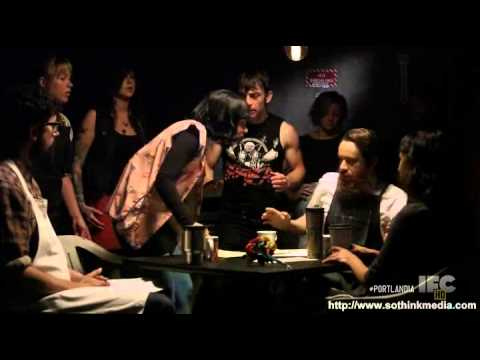

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [1]:
%pwd

'/home/jose/Documents/lambdaRepos/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [2]:
# Imports
from collections import Counter

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import spacy
from spacy.tokenizer import Tokenizer 
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [57]:
shops.shape

(7616, 6)

In [4]:
# Remove date, check-ins and extra space from reviews
shops["review_text"] = shops["full_review_text"].str.replace('\d+/\d+/\d+', '')
shops["review_text"] = shops["review_text"].str.replace('\d+\scheck-in |check-ins ', '')
shops["review_text"] = shops["review_text"].str.strip()
shops["review_text"] = shops["review_text"].str.lower()

In [5]:
shops["star_rating"] = (shops["star_rating"]
                       .str.replace("[^\d.\d]", '')
                       .astype("float64"))
shops.dtypes

coffee_shop_name     object
full_review_text     object
star_rating         float64
review_text          object
dtype: object

In [6]:
# Make review tokens
tokenizer = Tokenizer(nlp.vocab)
tokens = []

for doc in tokenizer.pipe(shops["review_text"], batch_size=500):
    doc_token = [token.text for token in doc]
    tokens.append(doc_token)

In [7]:
# Remove stop words
tokens = []
for doc in tokenizer.pipe(shops["review_text"], batch_size=500):

    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text)
            
    tokens.append(doc_tokens)
    
shops["tokens"] = tokens

In [8]:
# Helpful counting function
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

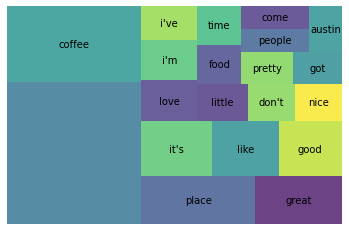

In [9]:
# Visualize current state of words
# (prior to lemmatization and extending stop words)
wc = count(shops["tokens"])
top_20 = wc[wc["rank"] <= 20]

squarify.plot(sizes=top_20["pct_total"], label=top_20["word"], alpha=.8)
plt.axis("off")
plt.show()

In [61]:
# Extend stop words
stopWords = nlp.Defaults.stop_words.union(["coffee", "i", "i've", 
                                           "i'm", "austin", "it's", 
                                           "place", "got", " ", "coffee.",
                                           "-", "$", "like", "good", "come",
                                           "drink", "try", "great", "say"])
tokens = []
for doc in tokenizer.pipe(shops["review_text"], batch_size=500):

    doc_tokens = []
    
    for token in doc:
        if token.text not in stopWords:
            doc_tokens.append(token.text)
            
    tokens.append(doc_tokens)
    
shops["tokens"] = tokens

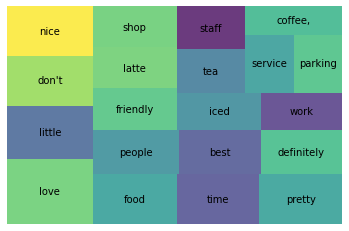

In [89]:
# After extending stop words
wc = count(shops["tokens"])
top_20 = wc[wc["rank"] <= 20]

squarify.plot(sizes=top_20["pct_total"], label=top_20["word"], alpha=.8)
plt.axis("off")
plt.show()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct


In [63]:
# Get lemmas
def get_lemmas(text):
    
    lemmas = []
    doc = nlp(text)
    
    for token in doc:
        if (
          ((token.text not in stopWords) and 
          (token.is_punct == False)) and
          (token.pos_ != "PRON")):
            lemmas.append(token.lemma_)
        
    return lemmas                

In [64]:
shops["lemmas"] = shops["review_text"].apply(get_lemmas)

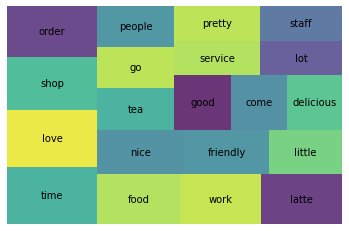

In [65]:
# lemmas
wc = count(shops["lemmas"])
top_20 = wc[wc["rank"] <= 20]

squarify.plot(sizes=top_20["pct_total"], label=top_20["word"], alpha=.8)
plt.axis("off")
plt.show()

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [66]:
# split data into good and bad coffee shops
good = shops[shops["star_rating"] >= 4]
bad = shops[shops["star_rating"] <= 3]

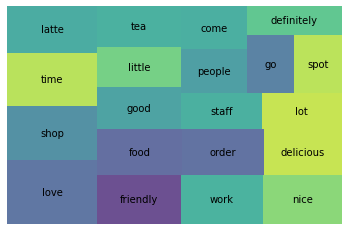

In [73]:
# good lemmas
wc = count(good["lemmas"])
top_20 = wc[wc["rank"] <= 20]

squarify.plot(sizes=top_20["pct_total"], label=top_20["word"], alpha=.8)
plt.axis("off")
plt.show()

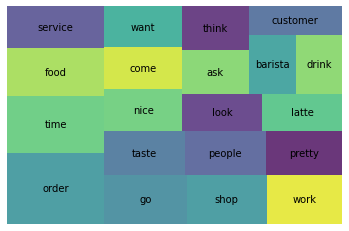

In [74]:
# bad lemmas
wc = count(bad["lemmas"])
top_20 = wc[wc["rank"] <= 20]

squarify.plot(sizes=top_20["pct_total"], label=top_20["word"], alpha=.8)
plt.axis("off")
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## My Analysis

In order to view each individual word along with the relative frequency, I'll merge the good and bad coffee shop word count tables and find the difference in total percentage. I can order them by the good percentage and/or the bad percentage to find large differences OR I can get an absolute difference just to see what the difference is as a whole and order them by that

In [69]:
badCount = count(bad["lemmas"])
goodCount = count(good["lemmas"])

In [70]:
merged = goodCount.merge(badCount, on="word", suffixes=("_good", "_bad"))
diff = merged[["word", "pct_total_good", "pct_total_bad"]].sort_values(by="pct_total_good", ascending=False)

In [88]:
badCount.loc[badCount["word"] == "say"]

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
566,say,186,267,24.0,0.003755,0.128347,0.126016


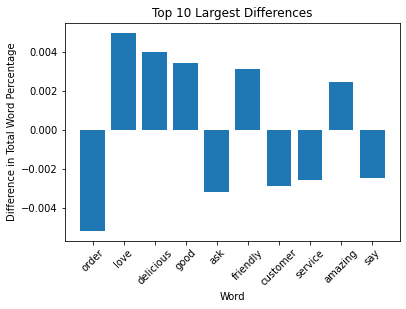

In [71]:
diff["abs_diff"] = abs(diff["pct_total_good"] - diff["pct_total_bad"])
diff["difference"] = diff["pct_total_good"] - diff["pct_total_bad"]
diff_sorted = diff.sort_values(by="abs_diff", ascending=False).head(10)

plt.bar(x="word", height="difference", data=diff_sorted)
plt.xticks(rotation=45)
plt.xlabel("Word")
plt.ylabel("Difference in Total Word Percentage")
plt.title("Top 10 Largest Differences")
plt.show()

From the chart above, it seems that customer complaints lean towards orders and customer service, whereas great coffee shop reviews tend to 
contain praise for how "great", "friendly" or "good" the coffee shop is. The word "delicious" also seems to be associated with good coffee shops, so it can be assumed that these locations place great emphasis on the quality of their food and drinks. 

#### Questionable Words

There are a few words that I wonder if I should keep in the analysis such as "great": I wonder if it may be redundant to use this word, given that it appears largely in favorably reviewed coffee shops. On the bad coffee shop side, I also wonder about the word "say". I'm not sure what this word is conveying. 

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

